In [150]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import diffmah
from diffmah import mah_halopop, DEFAULT_MAH_PARAMS
from jax import grad
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm

## vary logtc

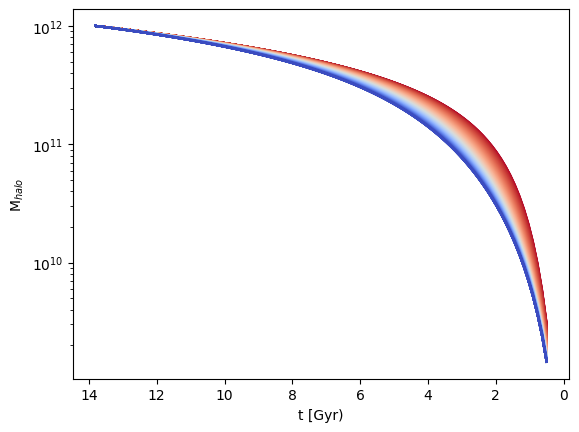

In [24]:
n_halos, n_times = 500, 100
tarr = np.linspace(0.5, 13.8, n_times)
logt0 = np.log10(tarr[-1])
colors=cm.coolwarm(np.linspace(1, 0, n_halos)) # red first

ZZ = np.zeros(n_halos)
logtc = np.log10(np.linspace(1, 5, n_halos))
logm0 = 12 + ZZ
early, late = 2 + ZZ, 1 + ZZ
t_peak = 14.0 + ZZ
mah_params = DEFAULT_MAH_PARAMS._make((logm0, logtc, early, late, t_peak))
dmhdt, log_mah = mah_halopop(mah_params, tarr, logt0)

fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
for ih in range(n_halos):
    __=ax.plot(tarr, 10**log_mah[ih, :], color=colors[ih])
ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.show()

## vary early index

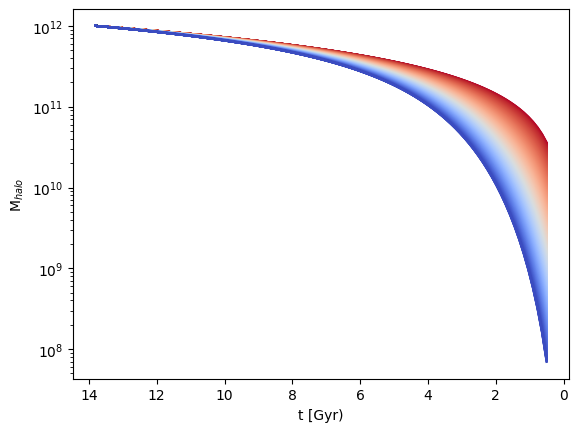

In [25]:
logtc = 0.5 + ZZ
early = np.linspace(1, 3, n_halos)
late = 1 + ZZ
mah_params = DEFAULT_MAH_PARAMS._make((logm0, logtc, early, late, t_peak))
dmhdt, log_mah = mah_halopop(mah_params, tarr, logt0)


fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
for ih in range(n_halos):
    __=ax.plot(tarr, 10**log_mah[ih, :], color=colors[ih])

ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.show()

## vary late index

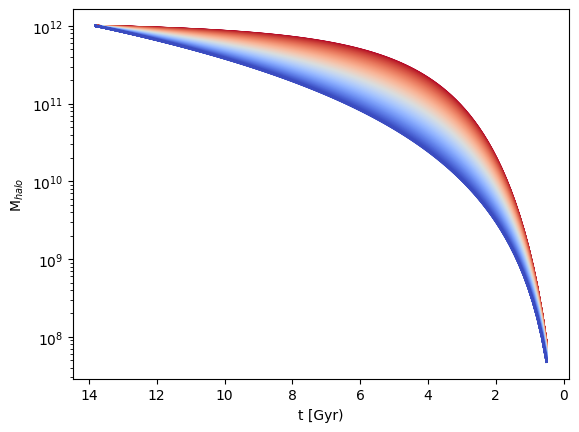

In [26]:
tauc = 2.0 
early = 3 + ZZ
late = np.linspace(0.01, 3, n_halos)
mah_params = DEFAULT_MAH_PARAMS._make((logm0, logtc, early, late, t_peak))
dmhdt, log_mah = mah_halopop(mah_params, tarr, logt0)

fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
for ih in range(n_halos):
    __=ax.plot(tarr, 10**log_mah[ih, :], color=colors[ih])

ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.show()

In [27]:
from jax import random as jran
ran_key = jran.key(10)

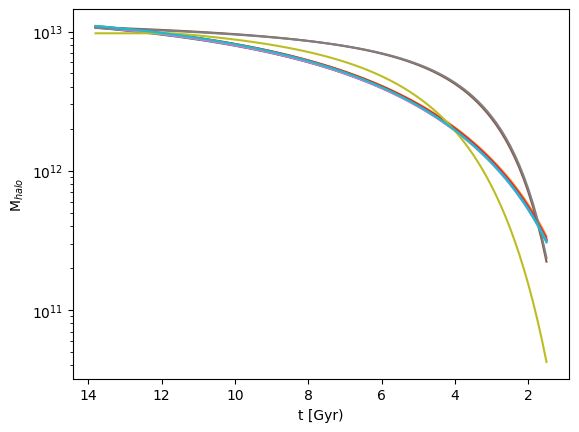

In [31]:
from diffmah.diffmahpop_kernels import mc_cenpop, DEFAULT_DIFFMAHPOP_PARAMS

cosmic_time = np.linspace(1.5, 13.8, 100)

n_halos = 10
lgm_obs = np.zeros(n_halos) + 13
t_obs = np.zeros(n_halos) + 13.8

halopop = mc_cenpop(DEFAULT_DIFFMAHPOP_PARAMS, cosmic_time, lgm_obs, t_obs, ran_key, logt0)

fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
for ih in range(n_halos):
    __=ax.plot(cosmic_time, 10**halopop.log_mah[ih, :])

ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.show()

In [212]:
pwd

'/Users/kumail'

## Optimization routine

#### Define Fiducial Model

In [86]:
ZZ = np.zeros(1)
logtc = np.log10(2)+ZZ
logm0 = 13 + ZZ
early, late = 2 + ZZ, 1 + ZZ
t_peak = 14.0 + ZZ
tarr = np.linspace(0.5, 13.8, 100)
logt0 = np.log10(tarr[-1])

In [87]:
mah_params = DEFAULT_MAH_PARAMS._make((logm0, logtc, early, late, t_peak))
dmhdt, log_mah = mah_halopop(mah_params, tarr, logt0)

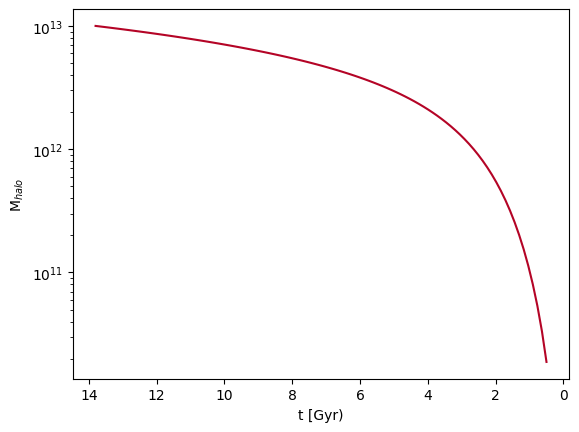

In [88]:
fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
__=ax.plot(tarr, 10**log_mah[0, :], color=colors[0])

ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.show()

#### Define the Loss Function

In [96]:
tarr = np.linspace(0.5, 13.8, 100)

In [140]:
def diffmah_model(theta, tarr):
    logtc = theta["logtc"]
    early = theta["early"]
    late = theta["late"]

    ZZ = jnp.zeros(1)
    
    logt0 = jnp.log10(tarr[-1])

    #fixed parameters
    logm0_arr = 13. + ZZ
    t_peak_arr = 14.0 + ZZ

    #fitting parameters
    logtc_arr = logtc + ZZ
    early_arr = early + ZZ
    late_arr = late + ZZ


    mah_params = DEFAULT_MAH_PARAMS._make((logm0_arr, logtc_arr, early_arr, late_arr, t_peak_arr))
    dmhdt, log_mah = mah_halopop(mah_params, tarr, logt0)

    return log_mah[0]

In [177]:
mhalo_true = diffmah_model(dict(logtc=jnp.log10(2), early=2, late=1), tarr)
mhalo_guess = diffmah_model(dict(logtc=jnp.log10(3), early=1, late=2), tarr)

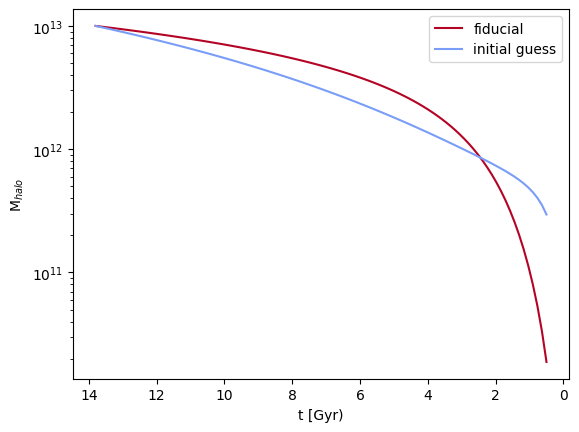

In [178]:
fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
__=ax.plot(tarr, 10**mhalo_true, color=colors[0], label='fiducial')
__=ax.plot(tarr, 10**mhalo_guess, color=colors[400], label='initial guess')


ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.legend()
plt.show()

In [179]:
def mse(mhalo_true: jnp.ndarray, mhalo_pred: jnp.ndarray) -> float:
    """Mean squared error function."""
    return jnp.mean(jnp.power(mhalo_true - mhalo_pred, 2))

In [180]:
def mseloss(theta, model, tarr, mhalo_true):
    mhalo_pred = model(theta, tarr)
    return mse(mhalo_true, mhalo_pred)

In [189]:
dmseloss = grad(mseloss)

In [197]:
dmseloss(dict(logtc=jnp.log10(3.), early=1., late=2.), diffmah_model, tarr, mhalo_true) 

{'early': Array(-0.11640245, dtype=float32, weak_type=True),
 'late': Array(0.02645773, dtype=float32, weak_type=True),
 'logtc': Array(0.01625249, dtype=float32)}

In [206]:
def model_optimization_loop(theta, model, loss, dloss, tarr, mhalo_true, n_steps=30000, step_size=0.001):
    
    
    losses = []
    
    for i in range(0, n_steps):
        
        grads = dloss(dict(logtc=theta["logtc"], early=theta["early"], late=theta["late"]), model, tarr, mhalo_true)
        
        theta["logtc"] = theta["logtc"] - step_size*grads["logtc"]
        theta["early"] = theta["early"] - step_size*grads["early"]
        theta["late"]  = theta["late"]  - step_size*grads["late"]

        losses.append(loss(dict(logtc=theta["logtc"], early=theta["early"], late=theta["late"]), model, tarr, mhalo_true))

    return losses, theta

In [207]:
losses, theta = model_optimization_loop(dict(logtc=jnp.log10(3.), early=1., late=2.),
                                             diffmah_model, mseloss, dmseloss, tarr, mhalo_true)

In [208]:
mhalo_fit = diffmah_model(dict(logtc=theta["logtc"], early=theta["early"], late=theta["late"]), tarr)

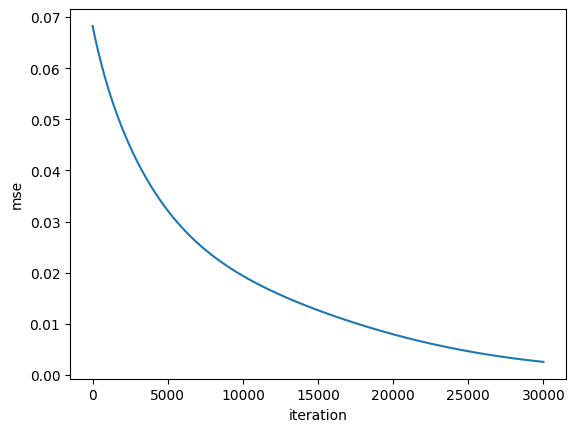

In [209]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

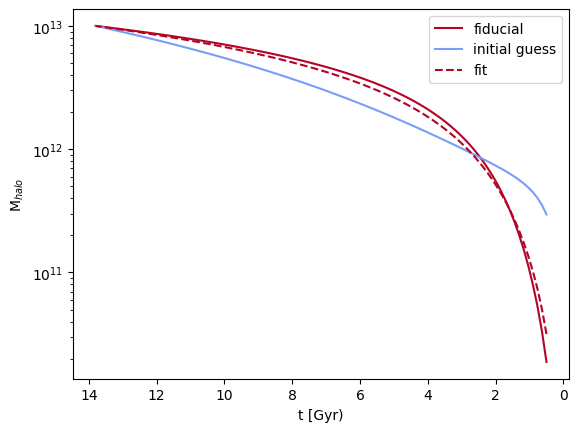

In [211]:
fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
__=ax.plot(tarr, 10**mhalo_true, color=colors[0], label='fiducial')
__=ax.plot(tarr, 10**mhalo_guess, color=colors[400], label='initial guess')
__=ax.plot(tarr, 10**mhalo_fit, color=colors[0], ls='--', label='fit')



ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.legend()
plt.show()